In [3]:
import gc
import torch


def clear_gpu_memory() -> None:
    torch.cuda.empty_cache()
    variables = gc.collect()
    del variables

In [4]:
import pandas as pd

In [5]:
images = []
lesions = []
from skimage.io import imread
import os


root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [6]:
from skimage.transform import resize


size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [7]:
import numpy as np


X = np.array(X, np.float32)
Y = np.array(Y, np.float32)

print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, нарисуем несколько изображений

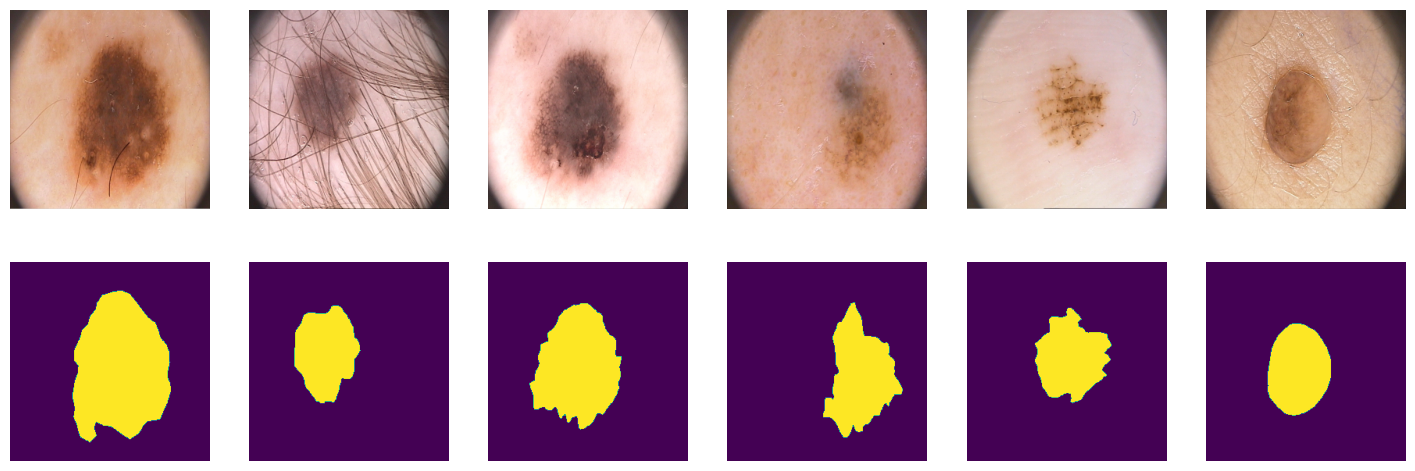

In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show()

In [9]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [10]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [11]:
from torch.utils.data import DataLoader
batch_size = 6
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [12]:
import torch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Реализация архитектур

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [23]:
class BlockBuilder:
    
    @staticmethod
    def create_enc_dec_block(in_dim: int, out_dim: int, is_last=False) -> nn.Sequential:
        block = []
        block.append(
            nn.Sequential(
                nn.Conv2d(in_channels=in_dim, out_channels=out_dim, kernel_size=3, padding=1),
                nn.BatchNorm2d(num_features=out_dim),
                nn.ReLU()
            )
        )
        if is_last:
            block.append(
                nn.Conv2d(in_channels=out_dim, out_channels=1, kernel_size=3, padding=1)
            )
        else:
            block.append(
                nn.Sequential(
                    nn.Conv2d(in_channels=out_dim, out_channels=out_dim, kernel_size=3, padding=1),
                    nn.BatchNorm2d(num_features=out_dim),
                    nn.ReLU()
                )    
            )

        return nn.Sequential(*block)
    
    @staticmethod
    def create_pool_block(is_unpool=False, return_indices=True):
        if is_unpool:
            block = nn.MaxUnpool2d(2, stride=2)
        else:
            block = nn.MaxPool2d(2, stride=2, return_indices=return_indices)
            
        return block

## SegNet

In [138]:

class SegNet(nn.Module):
    
    def __init__(self):
        super().__init__()

        builder = BlockBuilder()

        # encoder
        self.enc_conv0 = builder.create_enc_dec_block(3, 64)
        self.pool0 = builder.create_pool_block()
        self.enc_conv1 = builder.create_enc_dec_block(64, 128)
        self.pool1 = builder.create_pool_block()
        self.enc_conv2 = builder.create_enc_dec_block(128, 256)
        self.pool2 = builder.create_pool_block()
        self.enc_conv3 = builder.create_enc_dec_block(256, 512)
        self.pool3 = builder.create_pool_block()

        # bottleneck
        self.bottleneck_conv_encoder = builder.create_enc_dec_block(512, 512)
        self.bottleneck_pool = builder.create_pool_block()
        self.bottleneck_unpool = builder.create_pool_block(True)
        self.bottleneck_conv_decoder = builder.create_enc_dec_block(512, 512)

        # decoder
        self.upsample0 = builder.create_pool_block(True)
        self.dec_conv0 = builder.create_enc_dec_block(512, 256)
        self.upsample1 = builder.create_pool_block(True)
        self.dec_conv1 = builder.create_enc_dec_block(256, 128)
        self.upsample2 = builder.create_pool_block(True)
        self.dec_conv2 = builder.create_enc_dec_block(128, 64)
        self.upsample3 = builder.create_pool_block(True)
        self.dec_conv3 = builder.create_enc_dec_block(64, 32, True)


    def forward(self, x):
        # encoder
        size0 = x.size()
        e0, ind_0 = self.pool0(self.enc_conv0(x))
        size1 = e0.size()
        e1, ind_1 = self.pool1(self.enc_conv1(e0))
        size2 = e1.size()
        e2, ind_2 = self.pool2(self.enc_conv2(e1))
        size3 = e2.size()
        e3, ind_3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        size4 = e3.size()
        b_e = self.bottleneck_conv_encoder(e3)
        b_p, ind_b = self.bottleneck_pool(b_e)
        b_u = self.bottleneck_unpool(b_p, ind_b, output_size=size4)
        b_d = self.bottleneck_conv_decoder(b_u)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b_d, ind_3, output_size=size3))
        d1 = self.dec_conv1(self.upsample1(d0, ind_2, output_size=size2))
        d2 = self.dec_conv2(self.upsample2(d1, ind_1, output_size=size1))
        d3 = self.dec_conv3(self.upsample3(d2, ind_0, output_size=size0))
        return d3
    

## Метрика

In [24]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2)) 
    union = (outputs | labels).float().sum((1, 2))        
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10
    
    return thresholded

## Функция потерь

In [25]:
def bce_loss(y_real, y_pred, e=1e-10):
    result = torch.mean(
        y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred) + e)
    )
    return result

## Тренировка

In [26]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    loss_train = []
    loss_test = []
    iou_train = []
    iou_test = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        avg_iou = 0
        model.train()  
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device) 

            opt.zero_grad()

            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) 
            loss.backward()  
            opt.step() 

            Y_pred = torch.sigmoid(Y_pred)
            Y_pred = torch.where(Y_pred > 0.5, 1, 0)

            avg_iou += iou_pytorch(Y_pred, Y_batch).mean().item() / len(data_tr)

            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        loss_train.append(avg_loss.detach().cpu())
        iou_train.append(avg_iou)

        with torch.no_grad():
            model.eval() 
            X_val = X_val.to(device)
            Y_hat = model(X_val)
            Y_hat = torch.where(Y_hat > 0.5, 1, 0)
            Y_hat = Y_hat.detach().cpu()
            X_val = X_val.cpu()
            epoch_loss_test = loss_fn(Y_val, Y_hat)
            epoch_iou_test = iou_pytorch(Y_hat, Y_val).mean().item()
            iou_test.append(epoch_iou_test)
            loss_test.append(epoch_loss_test)
        # Visualize tools
        clear_output(wait=True)
        Y_hat = Y_hat.detach().numpy()
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    loss_train = list(map(lambda x: x.item(), loss_train))
    loss_test = list(map(lambda x: x.item(), loss_test))
    iou_train = iou_train
    iou_test = iou_test
    return loss_train, loss_test, iou_train, iou_test

In [27]:
def predict(model, data):
    model.eval()
    Y_pred = [X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [28]:
def score_model(model, metric, data):
    model.eval()
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        Y_pred  = torch.where(Y_pred > 0.5, 1, 0)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Обучение

In [145]:
model = SegNet().to(device)

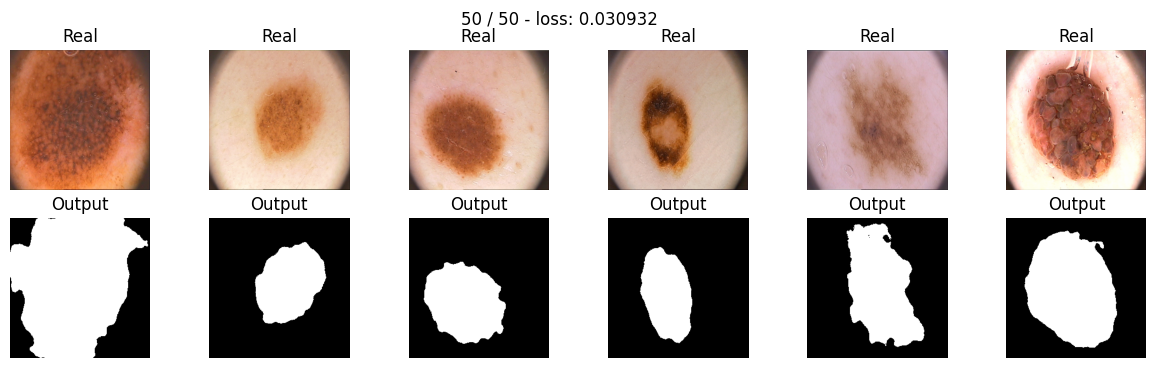

In [146]:
max_epochs = 50
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_train, loss_test, iou_train, iou_test = train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [34]:
def save_result(loss_train, loss_test, iou_train, iou_test, name):
    result = pd.DataFrame({'loss_train': loss_train, 'loss_test': loss_test,\
                       'iou_train': iou_train, 'iou_test': iou_test})
    result.to_csv(name, index=False)

In [148]:
save_result(loss_train, loss_test, iou_train, iou_test, 'segnet_bce.csv')

In [149]:
score_model(model, iou_pytorch, data_val)

0.7740741107198927

In [150]:
clear_gpu_memory()

Ответьте себе на вопрос: не переобучается ли моя модель?

## Другие функции потерь 

In [19]:
def dice_loss(y_real, y_pred):
    y_pred = y_pred.sigmoid()
    num = 2 * (y_real * y_pred).sum()
    den = (y_real + y_pred).sum()
    res = 1 - num/den
    return res 

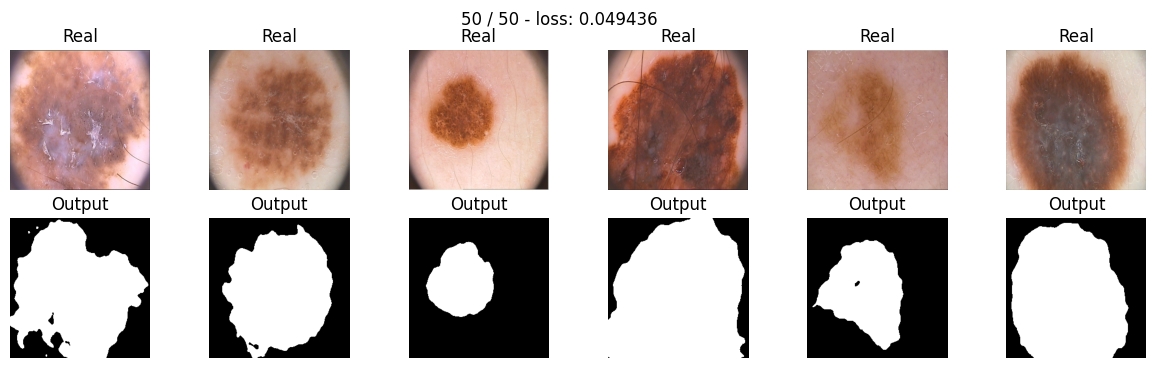

In [152]:
model_dice = SegNet().to(device)

max_epochs = 50
optim = torch.optim.Adam(model_dice.parameters(), lr=1e-4)
loss_train, loss_test, iou_train, iou_test = train(model_dice, optim, dice_loss, max_epochs, data_tr, data_val)

In [153]:
save_result(loss_train, loss_test, iou_train, iou_test, 'segnet_dice.csv')

In [154]:
score_model(model_dice, iou_pytorch, data_val)

0.7685185737080045

In [155]:
clear_gpu_memory()

In [20]:
def focal_loss(y_real, y_pred, eps=1e-8, gamma=2):
    result = - torch.mean(
        (1 - torch.sigmoid(y_pred)) ** gamma * y_real *\
         torch.log(torch.sigmoid(y_pred) + eps) + (1 - y_real) *\
          torch.log(1 - torch.sigmoid(y_pred) + eps)
    )
    return result


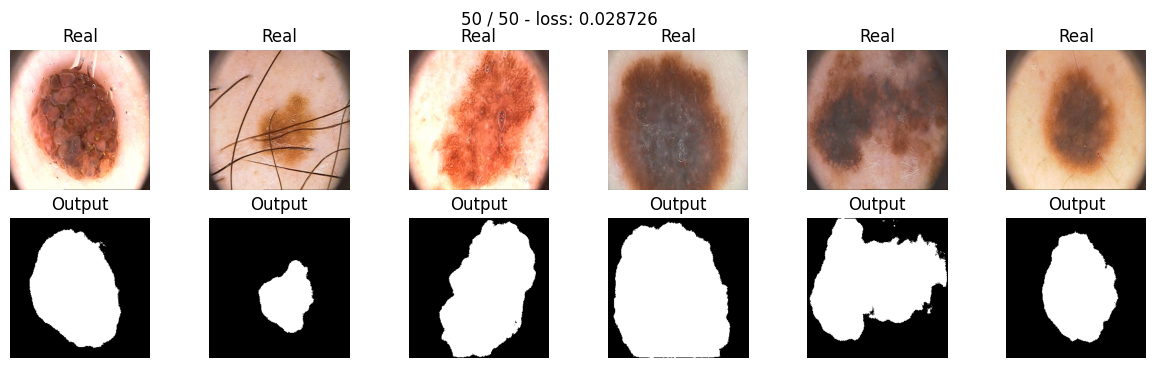

In [157]:
model_focal = SegNet().to(device)

max_epochs = 50
optimizer = torch.optim.Adam(model_focal.parameters(), lr=1e-4)
loss_train, loss_test, iou_train, iou_test = train(model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val)

In [158]:
save_result(loss_train, loss_test, iou_train, iou_test, 'segnet_focal.csv')

In [159]:
score_model(model_focal, iou_pytorch, data_val)

0.772222273879581

In [160]:
clear_gpu_memory()

In [29]:
def binary_tversky_loss(target, pred,
                        alpha=0.3,
                        beta=0.7,
                        smooth=1):
    batch_size = pred.shape[0]

    pred = torch.sigmoid(pred).view(batch_size, -1)
    target = target.view(batch_size, -1)

    TP = torch.sum(pred * target, dim=1)
    FP = torch.sum(pred * (1 - target), dim=1)
    FN = torch.sum((1 - pred) * target, dim=1)
    tversky = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)

    result = 1 - tversky
    return torch.mean(result)

## UNet

In [30]:
class UNet(nn.Module):
    
    def __init__(self):
        super().__init__()

        builder = BlockBuilder()
        

        self.enc_conv0 = builder.create_enc_dec_block(3, 64)
        self.pool0 = builder.create_pool_block(return_indices=False)
        self.enc_conv1 = builder.create_enc_dec_block(64, 128)
        self.pool1 = builder.create_pool_block(return_indices=False)
        self.enc_conv2 = builder.create_enc_dec_block(128, 256)
        self.pool2 = builder.create_pool_block(return_indices=False)
        self.enc_conv3 = builder.create_enc_dec_block(256, 512)
        self.pool3 = builder.create_pool_block(return_indices=False)

        self.bottleneck_conv = builder.create_enc_dec_block(512, 1024)

        self.upsample0 = nn.Upsample(32)
        self.dec_conv0 = builder.create_enc_dec_block(1024+512, 512)
        self.upsample1 = nn.Upsample(64)
        self.dec_conv1 = builder.create_enc_dec_block(512+256, 256)
        self.upsample2 = nn.Upsample(128)
        self.dec_conv2 = builder.create_enc_dec_block(256+128, 128)
        self.upsample3 = nn.Upsample(256)
        self.dec_conv3 = builder.create_enc_dec_block(128+64, 32, True)

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        d0 = self.upsample0(b)
        d0 = torch.cat([d0, e3], dim=1)
        d0 = self.dec_conv0(d0)

        d1 = self.upsample1(d0)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec_conv1(d1)

        d2 = self.upsample2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec_conv2(d2)
        
        d3 = self.upsample3(d2)
        d3 = torch.cat([d3, e0], dim=1)
        d3 = self.dec_conv3(d3)  # no activation
        return d3

In [224]:
unet_model = UNet().to(device)

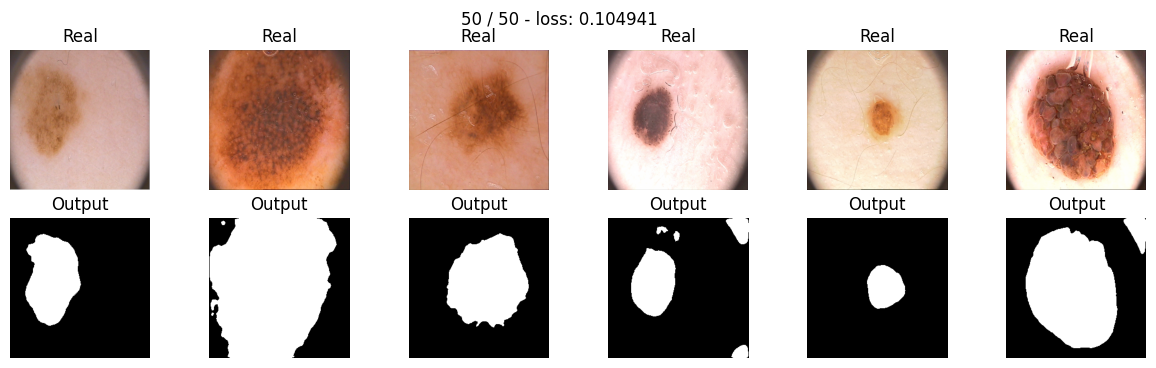

In [225]:
max_epochs = 50
optimizer = torch.optim.Adam(unet_model.parameters(), lr = 1e-4)
loss_train, loss_test, iou_train, iou_test = train(unet_model, optimizer, bce_loss, max_epochs, data_tr, data_val)

In [226]:
save_result(loss_train, loss_test, iou_train, iou_test, 'unet_bce.csv')

In [227]:
score_model(unet_model, iou_pytorch, data_val)

0.7500000331136916

In [228]:
clear_gpu_memory()

## UNet 2

In [31]:
class UNet2(UNet):

    def __init__(self) -> None:
        super().__init__()

        self.pool0 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2)
        self.pool1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)
        self.pool2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=2)
        self.pool3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, stride=2)

        self.upsample0 = nn.ConvTranspose2d(in_channels=1024, out_channels=1024, kernel_size=2, stride=2)
        self.upsample1 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2)
        self.upsample2 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2)
        self.upsample3 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)

In [45]:
unet2_model = UNet2().to(device)

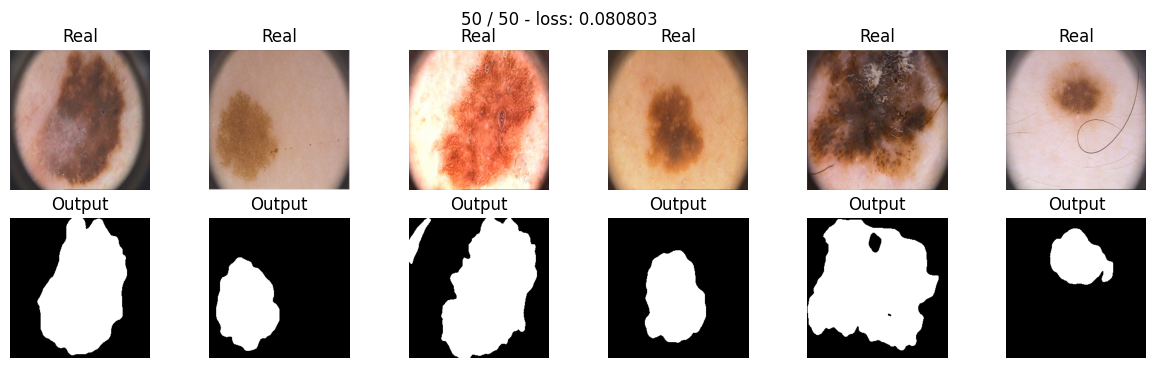

In [46]:
max_epochs = 50
optimizer = torch.optim.Adam(unet2_model.parameters(), lr = 1e-4)
loss_train, loss_test, iou_train, iou_test = train(unet2_model, optimizer, binary_tversky_loss, max_epochs, data_tr, data_val)
save_result(loss_train, loss_test, iou_train, iou_test, 'unet2_tversky.csv')

In [232]:
score_model(unet2_model, iou_pytorch, data_val)

0.727777812216017

In [233]:
clear_gpu_memory()

In [25]:
def train_with_loss(model, loss_function):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_train, loss_test, iou_train, iou_test = train(model, optimizer, loss_function, max_epochs, data_tr, data_val)
    score = score_model(model, iou_pytorch, data_val)
    print(f'score: {score}')
    return loss_train, loss_test, iou_train, iou_test

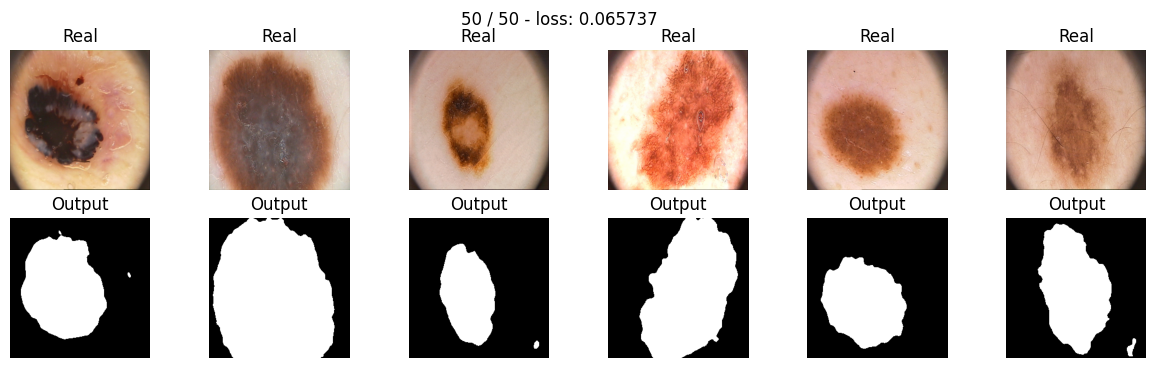

score: 0.751851863331265


In [235]:
segnet_tversky = SegNet().to(device)
loss_train, loss_test, iou_train, iou_test = train_with_loss(segnet_tversky, binary_tversky_loss)

save_result(loss_train, loss_test, iou_train, iou_test, 'segnet_tversky.csv')

In [236]:
clear_gpu_memory()

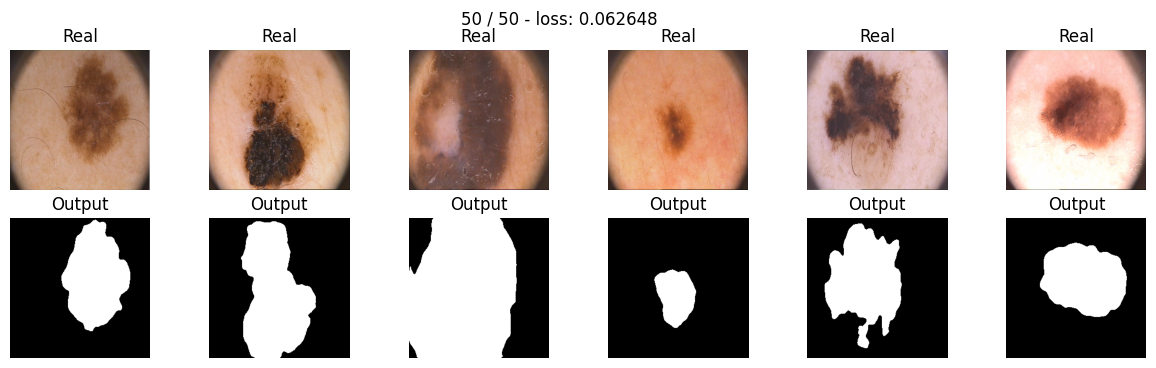

score: 0.8018518951204088


In [28]:
unet_dice = UNet().to(device)
loss_train, loss_test, iou_train, iou_test = train_with_loss(unet_dice, dice_loss)

save_result(loss_train, loss_test, iou_train, iou_test, 'unet_dice.csv')

In [29]:
clear_gpu_memory()

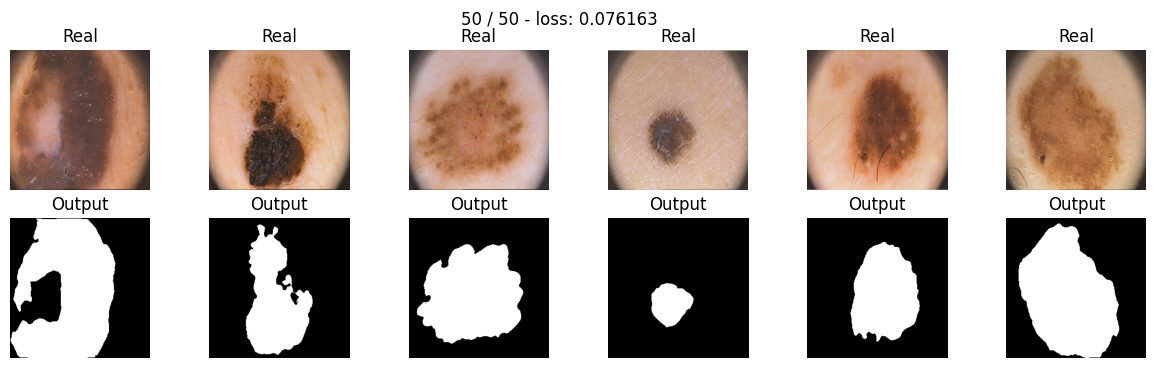

score: 0.6277778016196357


In [30]:
unet_focal = UNet().to(device)
loss_train, loss_test, iou_train, iou_test = train_with_loss(unet_focal, focal_loss)

save_result(loss_train, loss_test, iou_train, iou_test, 'unet_focal.csv')

In [31]:
clear_gpu_memory()

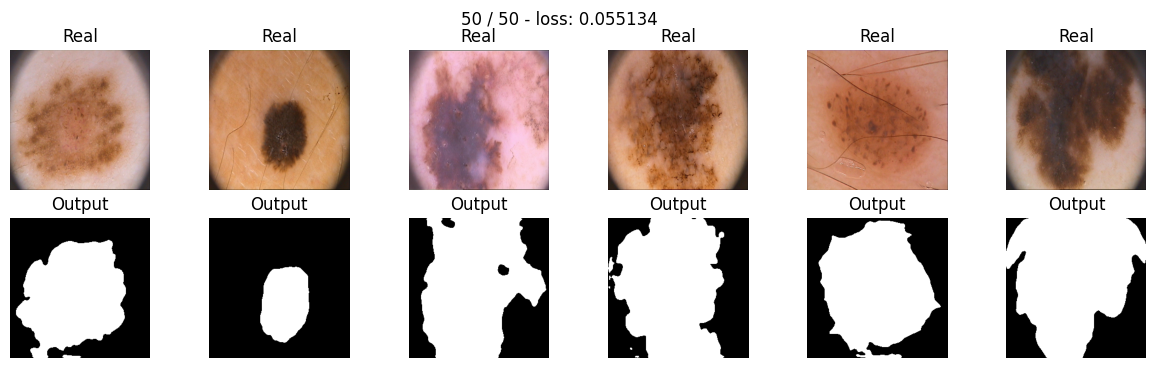

score: 0.7814815243085226


In [32]:
unet_tversky = UNet().to(device)
loss_train, loss_test, iou_train, iou_test = train_with_loss(unet_tversky, binary_tversky_loss)

save_result(loss_train, loss_test, iou_train, iou_test, 'unet_tversky.csv')

In [33]:
clear_gpu_memory()

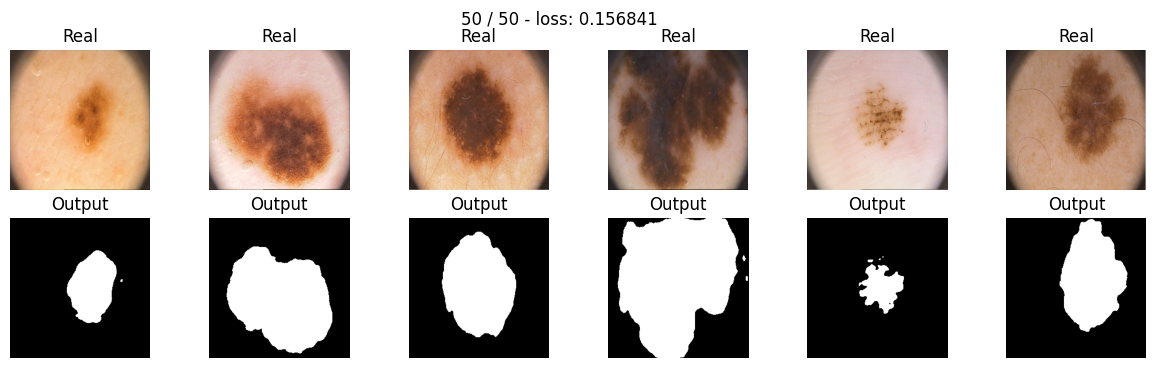

score: 0.698148164484236


In [34]:
unet2_bce = UNet2().to(device)
loss_train, loss_test, iou_train, iou_test = train_with_loss(unet2_bce, bce_loss)

save_result(loss_train, loss_test, iou_train, iou_test, 'unet2_bce.csv')

In [35]:
clear_gpu_memory()

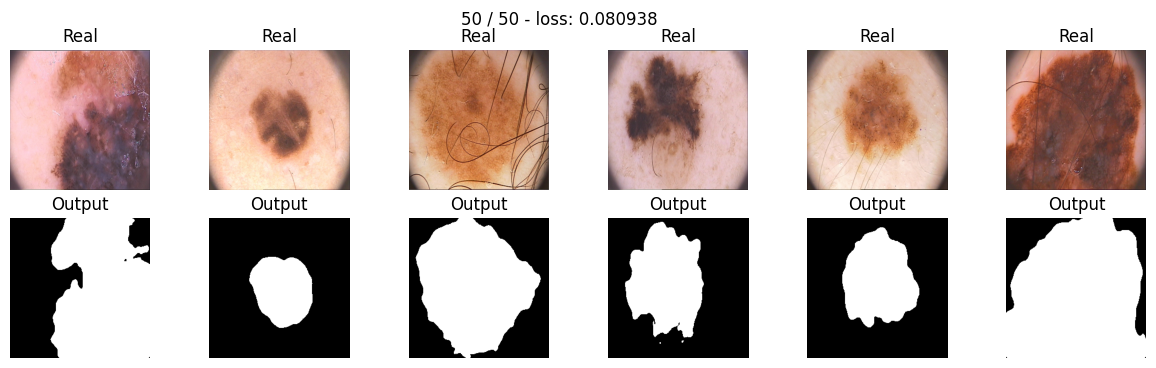

score: 0.8055555886692471


In [36]:
unet2_dice = UNet2().to(device)
loss_train, loss_test, iou_train, iou_test = train_with_loss(unet2_dice, dice_loss)

save_result(loss_train, loss_test, iou_train, iou_test, 'unet2_dice.csv')

In [37]:
clear_gpu_memory()

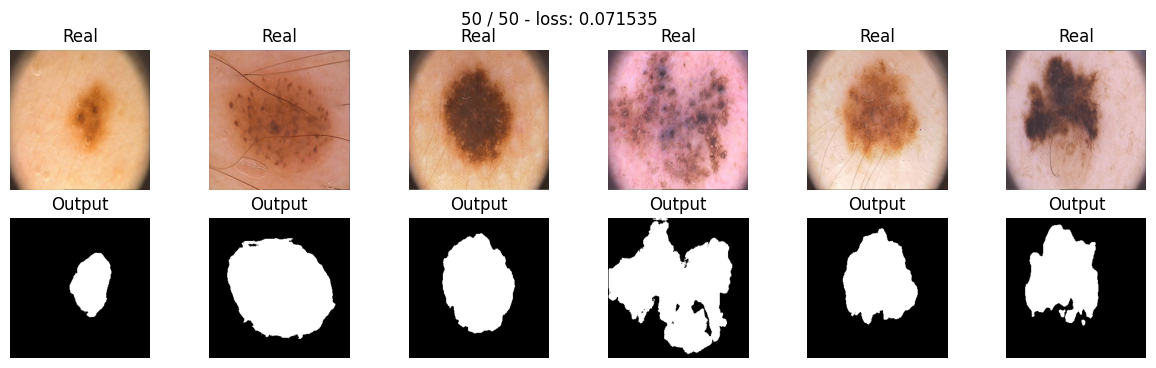

score: 0.6740741001235114


In [38]:
unet2_focal = UNet2().to(device)
loss_train, loss_test, iou_train, iou_test = train_with_loss(unet2_focal, focal_loss)

save_result(loss_train, loss_test, iou_train, iou_test, 'unet2_focal.csv')

In [39]:
clear_gpu_memory()

## Отчет по всем моделям

In [36]:
def combine_iou_losses(model_name):
    iou_losses = []
    for loss in ['bce', 'dice', 'focal', 'tversky']:
        df = pd.read_csv(f'{model_name}_{loss}.csv')
        iou_losses.append(df)
        
    train_losses = list(map(lambda x: x['loss_train'], iou_losses))
    test_losses = list(map(lambda x: x['loss_test'], iou_losses))
    train_iou = list(map(lambda x: x['iou_train'], iou_losses))
    test_iou = list(map(lambda x: x['iou_test'], iou_losses))
    return train_losses, test_losses, train_iou, test_iou

In [37]:
segnet_losses_train, segnet_losses_test, segnet_iou_train, segnet_iou_test = combine_iou_losses('segnet')
unet_losses_train, unet_losses_test, unet_iou_train, unet_iou_test = combine_iou_losses('unet')
unet2_losses_train, unet2_losses_test, unet2_iou_train, unet2_iou_test = combine_iou_losses('unet2')

In [38]:
def build_charts(train, test, graph_type, model_name):
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    axe = ax.ravel()
    losses = ['BCE', 'Dice', 'Focal', 'Tversky']
    for num, (train, val, loss) in enumerate(zip(train, test, losses)):
        axe[num].plot(range(max_epochs), train, label=f'train')
        axe[num].plot(range(max_epochs), val, label=f'val')
        axe[num].set_title(f'{model_name} {loss} {graph_type}')
        axe[num].legend()
    plt.tight_layout()

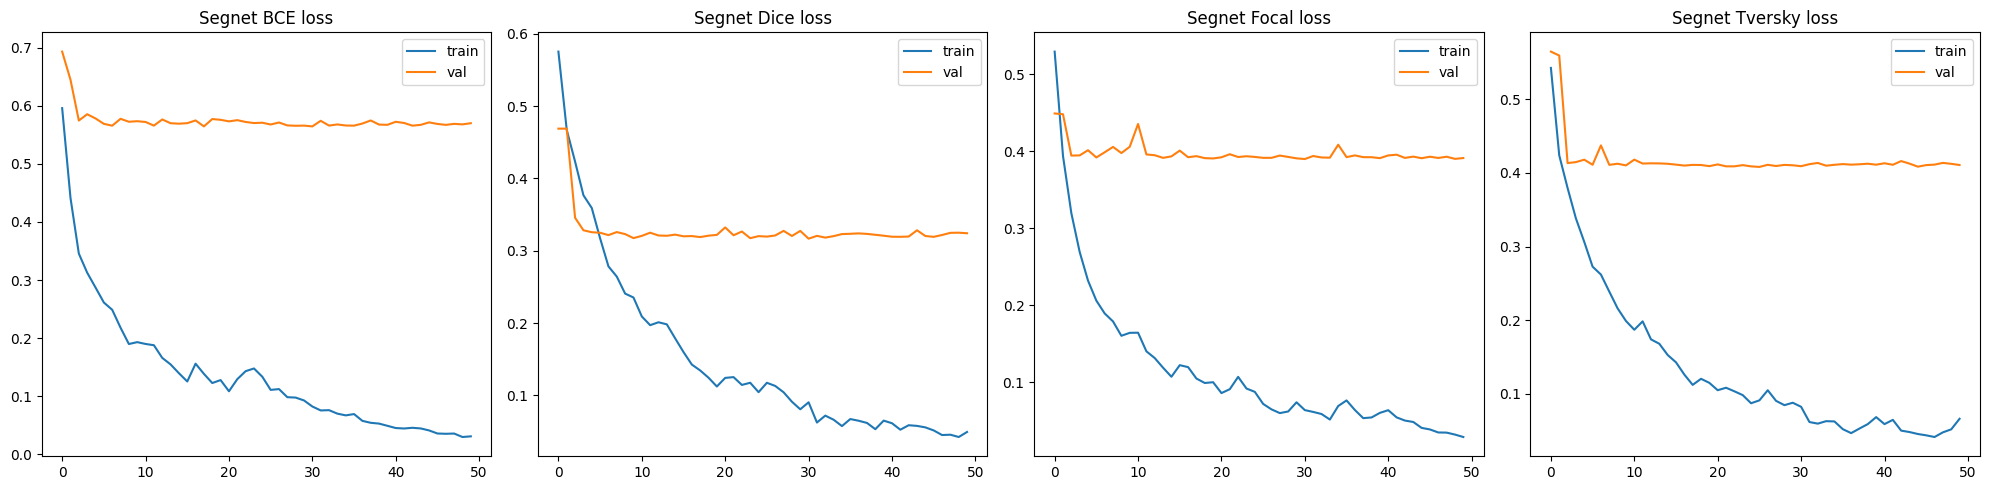

In [39]:
build_charts(segnet_losses_train, segnet_losses_test, 'loss', 'Segnet')

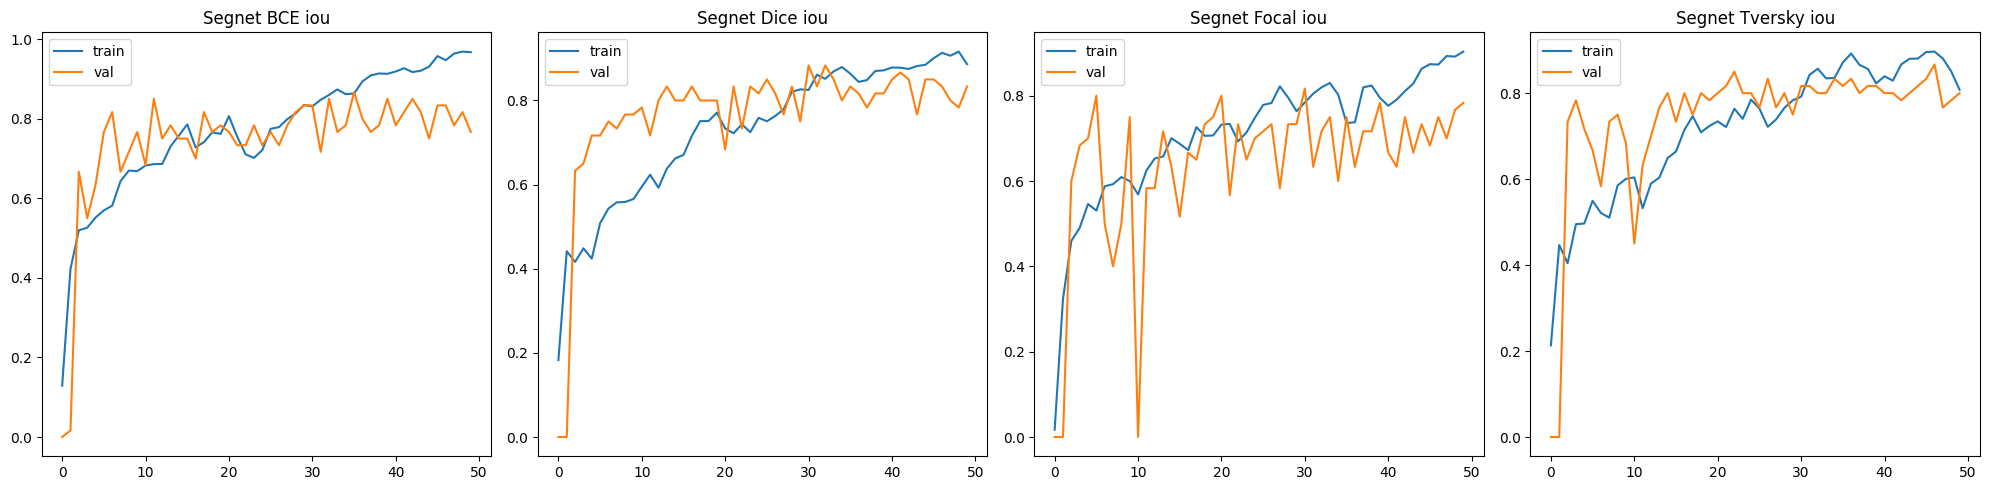

In [40]:
build_charts(segnet_iou_train, segnet_iou_test, 'iou', 'Segnet')

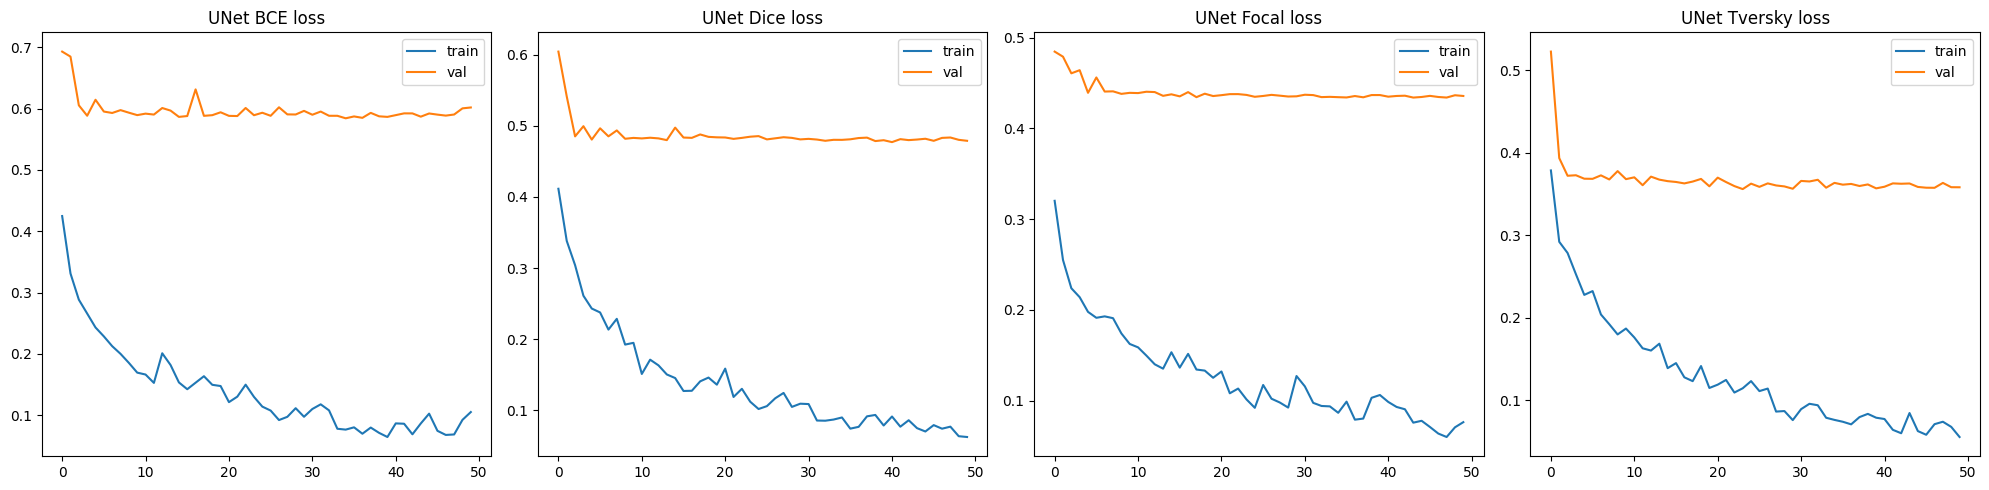

In [41]:
build_charts(unet_losses_train, unet_losses_test, 'loss', 'UNet')

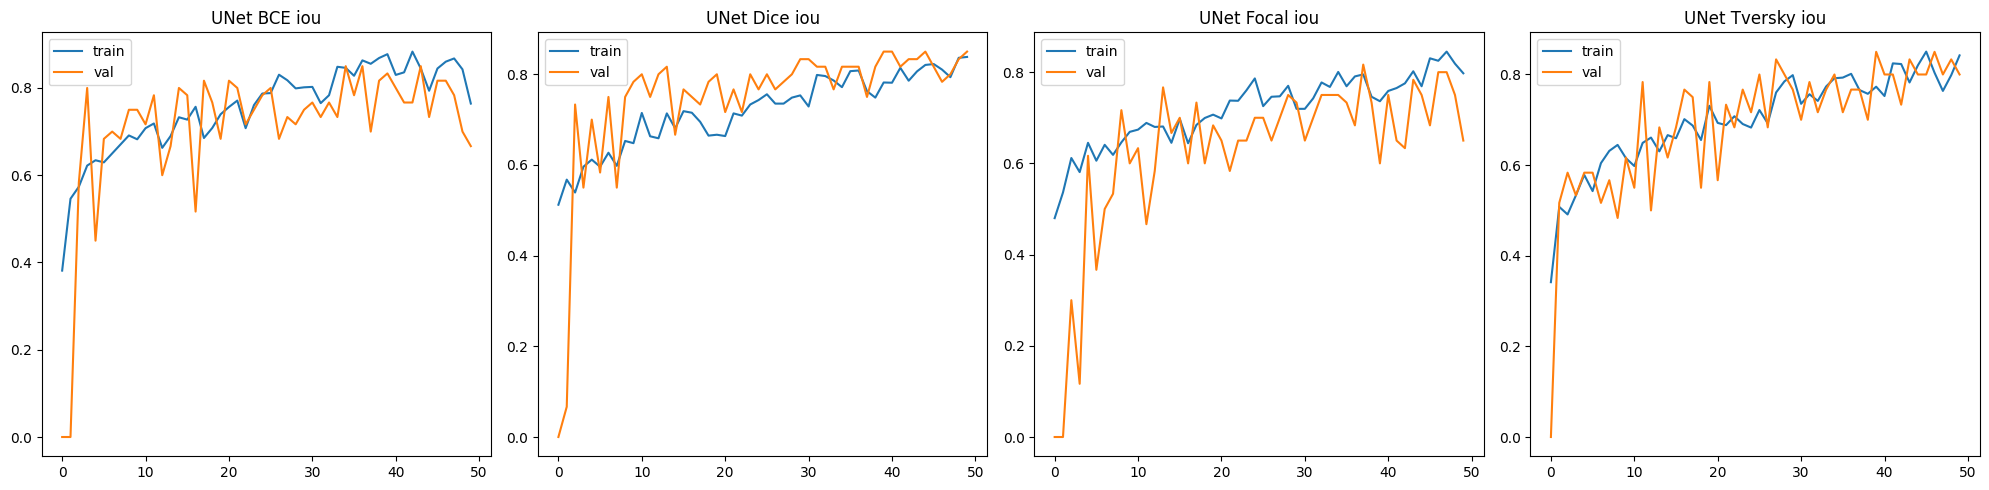

In [42]:
build_charts(unet_iou_train, unet_iou_test, 'iou', 'UNet')

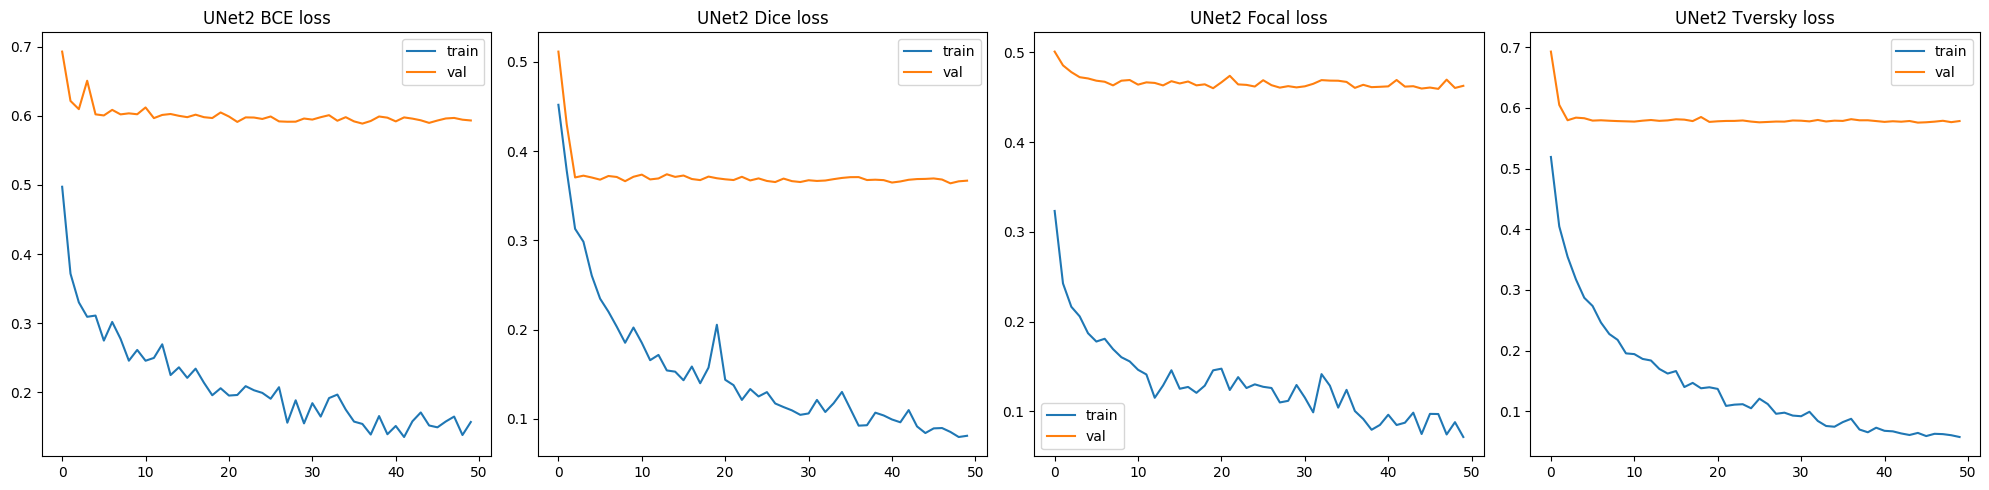

In [43]:
build_charts(unet2_losses_train, unet2_losses_test, 'loss', 'UNet2')

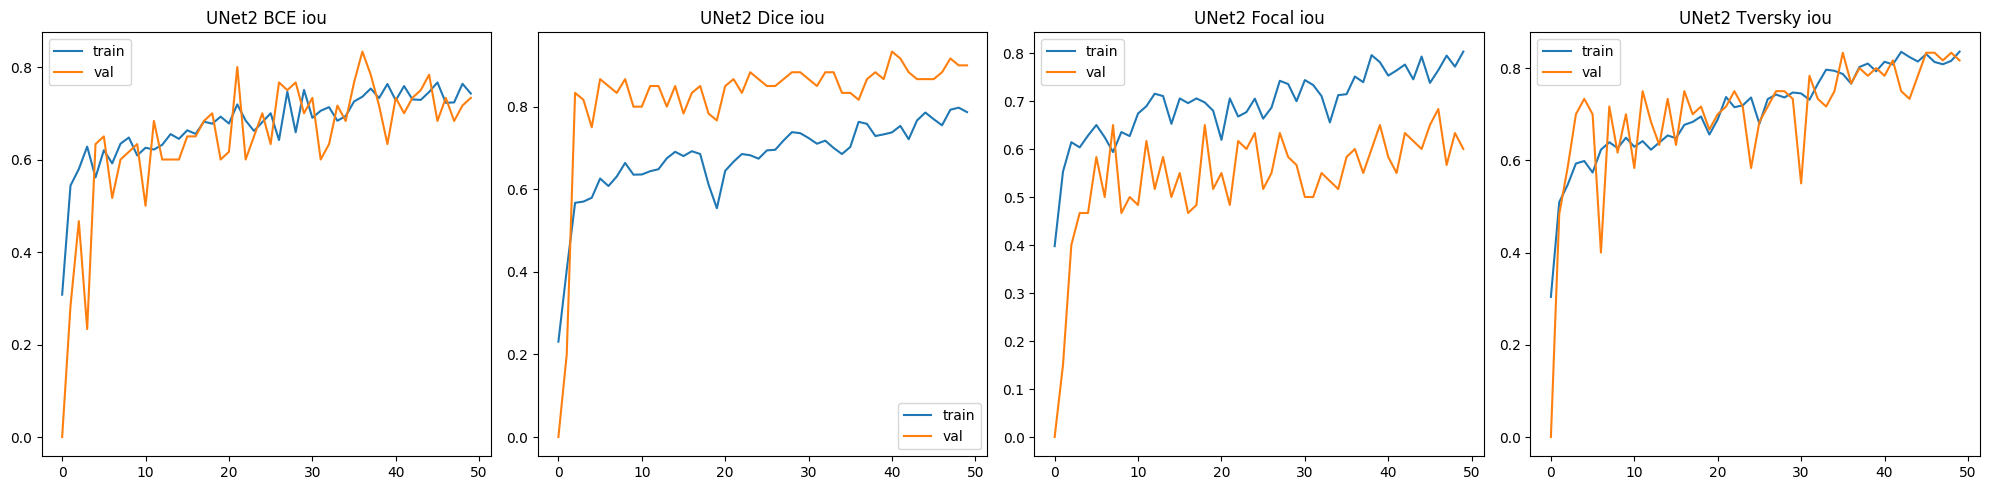

In [44]:
build_charts(unet2_iou_train, unet2_iou_test, 'iou', 'UNet2')